In [44]:
import pandas as pd
df = pd.read_csv("AIRPOL_data.csv",encoding="UTF-8",sep=";")
cols_to_drop = [ col for col in df.columns if col.startswith("Unnamed")]

df = df.drop(columns=cols_to_drop)
df.columns
cols_to_num = [col for col in df.iloc[:,4:]]
cols_to_num
for c in cols_to_num:
    df[c] = df[c].str.replace(",",".")
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df[df["Country"] != "All Countries"]
df = df.rename(columns = {
    "Outcome" : "Disease",
    "Value" : "Premature_Deaths"
})
df.head(4)

,Country,NUTS_Code,Air_Pollutant,Disease,Affected_Population,Populated_Area[km2],Air_Pollution_Average[ug/m3],Premature_Deaths
0,Albania,AL,NO2,Asthma,2337443.0,11299.0,5.5,103.0
1,Albania,AL,PM2.5,Asthma,456076.0,11299.0,11.3,231.0
2,Albania,AL0,NO2,Asthma,2337443.0,11299.0,5.5,103.0
3,Albania,AL0,PM2.5,Asthma,456076.0,11299.0,11.3,231.0


In [45]:
# grouping countries by 4 regions as requested:

regions = {
    "Western Europe": [
        "Austria", "Belgium", "France", "Germany", "Netherlands", "Switzerland"
    ],
    "Eastern Europe": [
        "Poland", "Czechia", "Hungary"
    ],
    "Southern Europe": [
        "Greece", "Spain", "Italy", "Portugal"
    ],
    "Northern Europe": [
        "Sweden", "Denmark", "Finland"
    ]
}

In [46]:
country_to_region = { country : region for region, countries in regions.items() for country in countries }
country_to_region
df["Region"] = df["Country"].map(country_to_region).fillna("Other")
df.columns
df_se = df[df["Region"] == "Southern Europe"].copy()

In [47]:
from math import ceil
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [48]:
#1. Crie um diagrama de correlação entre a variável Premature_Deaths e os restantes 
#   atributos e interprete.

P-valor do teste de normalidade (Lilliefors) para 'Premature_Deaths': 0.0010
Usando o método de correlação: Spearman


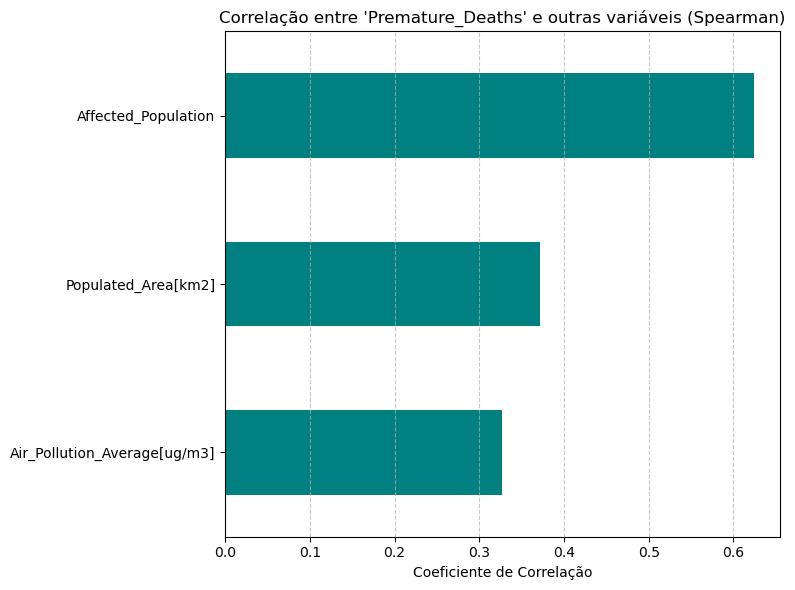

C:\Users\ruben\AppData\Local\Temp\ipykernel_22364\3642922162.py:69: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


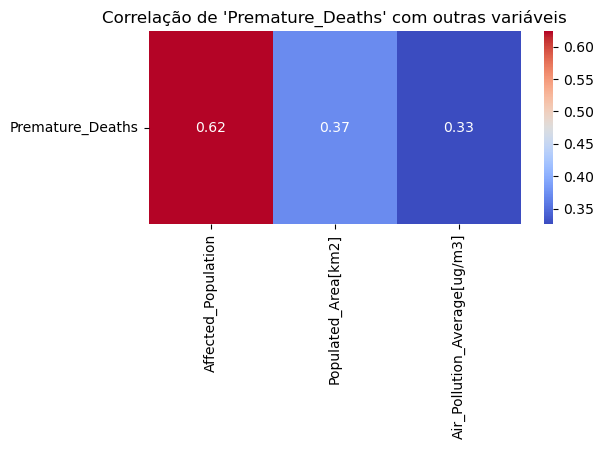

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import levene

# =====================================================
# Verificações Iniciais
# ====================================================

# Verificar se a coluna 'Premature_Deaths' existe
if "Premature_Deaths" not in df.columns:
    raise ValueError("'Premature_Deaths' não foi encontrado nas colunas do DataFrame.")

# Mapear países para regiões e filtrar apenas Southern Europe
df["Region"] = df["Country"].map(country_to_region).fillna("Other")
df_se = df[df["Region"] == "Southern Europe"].copy()

# Selecionar colunas numéricas
numeric_cols = df_se.select_dtypes(include=np.number).columns.tolist()

# Confirmar se 'Premature_Deaths' é numérica
if "Premature_Deaths" not in numeric_cols:
    raise ValueError("'Premature_Deaths' não é uma coluna numérica!")

# Atualizar colunas numéricas após a possível remoção dos outliers
numeric_cols = df_se.select_dtypes(include=np.number).columns.tolist()

# =====================================================
# Teste de Normalidade (Lilliefors)
# =====================================================

stat, p_val = lilliefors(df_se["Premature_Deaths"].dropna())
print(f"P-valor do teste de normalidade (Lilliefors) para 'Premature_Deaths': {p_val:.4f}")

# Escolher o método de correlação com base na normalidade
method = "pearson" if p_val > 0.05 else "spearman"
print(f"Usando o método de correlação: {method.capitalize()}")

# =====================================================
# Cálculo da Correlação
# =====================================================

# Matriz de correlação com todas as variáveis numéricas
corr_matrix = df_se[numeric_cols].corr(method=method)

# Extrair apenas a correlação com 'Premature_Deaths'
premature_corr = corr_matrix["Premature_Deaths"].drop("Premature_Deaths")

# =====================================================
# Visualização dos Resultados
# =====================================================

# Gráfico de barras horizontal com as correlações
plt.figure(figsize=(8, 6))
premature_corr.sort_values().plot(kind="barh", color="teal")
plt.title(f"Correlação entre 'Premature_Deaths' e outras variáveis ({method.capitalize()})")
plt.xlabel("Coeficiente de Correlação")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Heatmap apenas com correlação de Premature_Deaths vs restantes variáveis
plt.figure(figsize=(6, len(premature_corr) * 0.5 + 1))
sns.heatmap(premature_corr.to_frame().T, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlação de 'Premature_Deaths' com outras variáveis")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [52]:
#2. Usando o método k-fold cross validation obtenha um modelo regressão linear simples para 
#   a variável Premature_Deaths usando a variável Affected_Population 
#   a) Apresente a função linear resultante

In [55]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
#import numpy as np
#import pandas as pd

# =====================================================
# Preparação dos dados
# =====================================================
X = df_se[["Affected_Population"]]
y = df_se["Premature_Deaths"]

# =====================================================
# Configurar KFold Cross-Validation
# =====================================================
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Listas para armazenar métricas e modelos
r2_scores = []
mae_scores = []
rmse_scores = []
models = []

# =====================================================
# Loop pelos folds: treino e avaliação
# =====================================================
for i, (train_idx, test_idx) in enumerate(kf.split(X), 1):  # Começa a contagem no 1
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    intercept = model.intercept_
    coef = model.coef_[0]

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    models.append((intercept, coef))
    r2_scores.append(r2)
    mae_scores.append(mae)
    rmse_scores.append(rmse)

    print(f"\n🔹 Fold {i}")
    print(f"  - Intercepto: {intercept:.2f}")
    print(f"  - Coeficiente: {coef:.6f}")
    print(f"  - R²: {r2:.4f}")
    print(f"  - MAE: {mae:.2f}")
    print(f"  - RMSE: {rmse:.2f}")

# =====================================================
# Calcular a média dos parâmetros dos modelos
# =====================================================
mean_intercept = np.mean([m[0] for m in models])
mean_coef = np.mean([m[1] for m in models])

print(f"\nFunção linear resultante (média dos 5 folds):")
print(f"Premature_Deaths = {mean_intercept:.2f} + {mean_coef:.6f} * Affected_Population")


🔹 Fold 1
  - Intercepto: -13.05
  - Coeficiente: 0.000378
  - R²: 0.4116
  - MAE: 400.13
  - RMSE: 1513.21

🔹 Fold 2
  - Intercepto: 30.36
  - Coeficiente: 0.000334
  - R²: 0.3402
  - MAE: 457.57
  - RMSE: 2514.52

🔹 Fold 3
  - Intercepto: -71.03
  - Coeficiente: 0.000441
  - R²: -0.0276
  - MAE: 462.16
  - RMSE: 1734.67

🔹 Fold 4
  - Intercepto: -15.14
  - Coeficiente: 0.000393
  - R²: 0.2686
  - MAE: 405.47
  - RMSE: 1865.51

🔹 Fold 5
  - Intercepto: -0.34
  - Coeficiente: 0.000368
  - R²: 0.3155
  - MAE: 436.11
  - RMSE: 2235.23

Função linear resultante (média dos 5 folds):
Premature_Deaths = -13.84 + 0.000383 * Affected_Population


In [56]:
# b) Visualize a reta correspondente ao modelo de regressão linear simples e o respetivo 
# diagrama de dispersão.

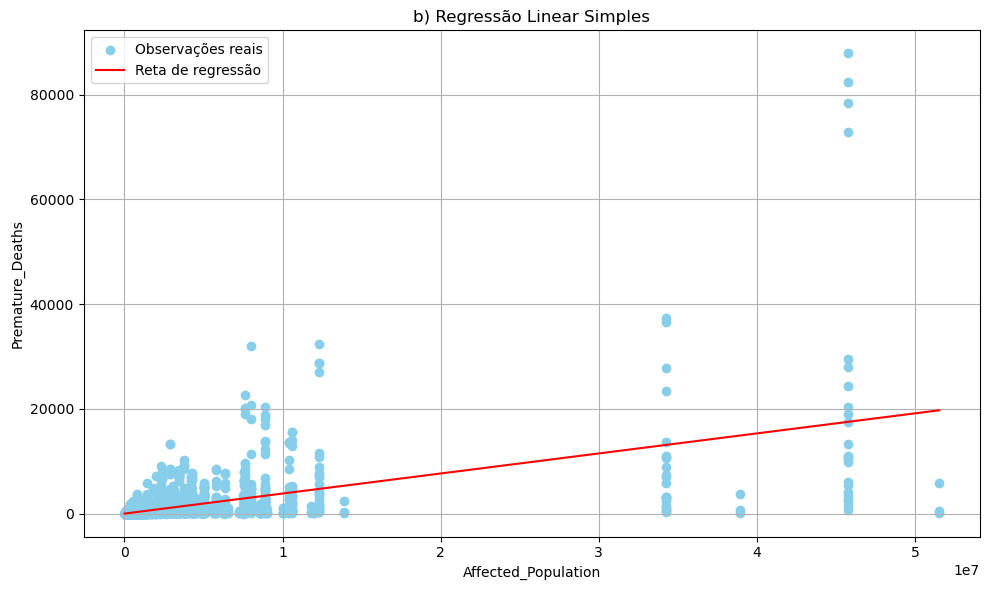

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# =====================================================
# Visualize a reta correspondente
# =====================================================

# Criar array X ordenado para desenhar a linha de regressão de forma suave
X_sorted = np.sort(X.values, axis=0)

# Calcular predições usando a função linear média
y_pred_line = mean_intercept + mean_coef * X_sorted

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color="skyblue", label="Observações reais")
plt.plot(X_sorted, y_pred_line, color="red", label="Reta de regressão")

plt.title("b) Regressão Linear Simples")
plt.xlabel("Affected_Population")
plt.ylabel("Premature_Deaths")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [58]:
# c) Calcule o erro médio absoluto (MAE) e raiz quadrada do erro médio (RMSE) do modelo 

In [59]:
# =====================================================
# Calcular e apresentar métricas médias do modelo
# =====================================================
mean_mae = np.mean(mae_scores)
mean_rmse = np.mean(rmse_scores)
mean_r2 = np.mean(r2_scores)

print(f"Coeficiente de determinação (R²) médio: {mean_r2:.4f}")
print(f"Erro médio absoluto (MAE) médio: {mean_mae:.4f}")
print(f"Raiz do erro quadrático médio (RMSE) médio: {mean_rmse:.4f}")

Coeficiente de determinação (R²) médio: 0.2617
Erro médio absoluto (MAE) médio: 432.2901
Raiz do erro quadrático médio (RMSE) médio: 1972.6275


In [32]:
# 3. Usando o método k-fold cross validation desenvolva modelos para prever 
# Premature_Deaths usando: 
# a) Regressão linear múltipla. 

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt


Nenhuma correlação alta (> 0.8) detectada entre as variáveis explicativas.


Função linear resultante (média dos 5 folds):
Premature_Deaths = 4.48 + (0.000289 * Affected_Population) + (0.032322 * Populated_Area[km2]) + (-2.122331 * Air_Pollution_Average[ug/m3])

Métricas médias:
R² médio: 0.2605
MAE médio: 447.8509
RMSE médio: 1973.7182


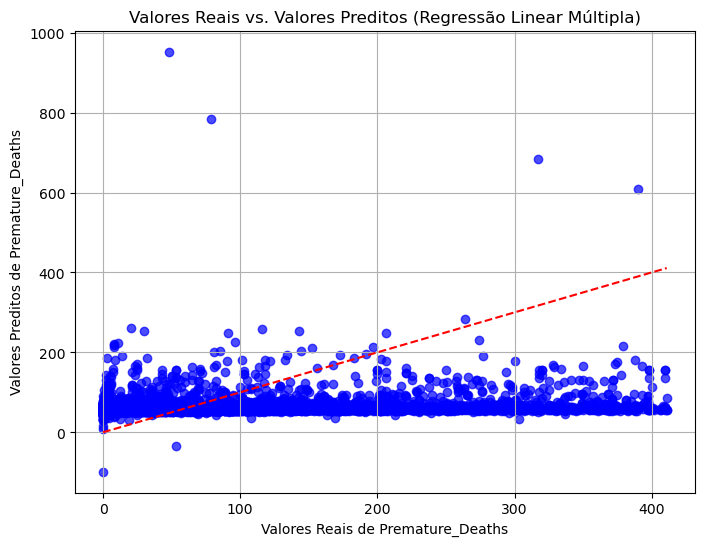

In [35]:
# 4.2
# 3. b) Árvore de regressão. Otimize os parâmetros do modelo. Apresente a árvore de 
#       regressão obtida.

Shapiro-Wilk Teste: estatística=0.1827, p-valor=0.0000
Os resíduos NÃO seguem uma distribuição normal (rejeita H0).


Melhores hiperparâmetros: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}

Métricas médias da árvore de regressão:
R² médio: 0.3407
MAE médio: 407.9126
RMSE médio: 1867.0348


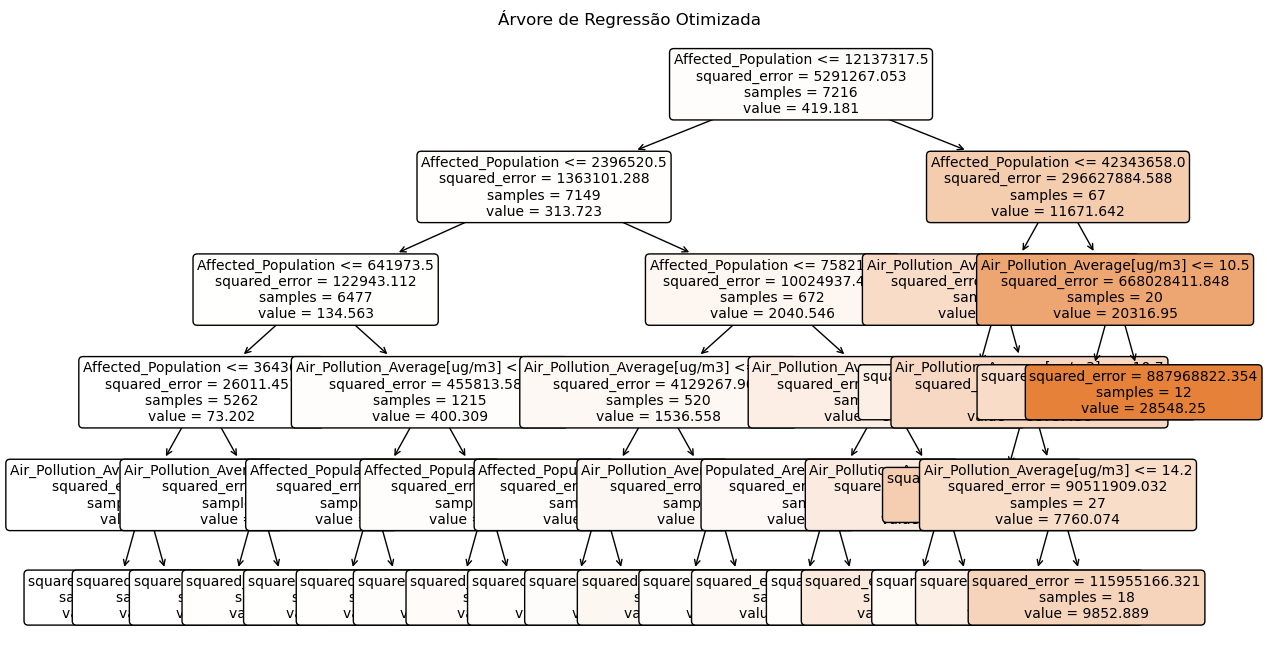

In [60]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# =====================================================
# Preparar as variáveis explicativas (features) e resposta (target)
# =====================================================
features = ["Affected_Population", "Populated_Area[km2]", "Air_Pollution_Average[ug/m3]"]
X = df_se[features]
y = df_se["Premature_Deaths"]

# =====================================================
# Definir o modelo base e os hiperparâmetros a testar
# =====================================================
tree = DecisionTreeRegressor(random_state=42)
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# =====================================================
# Usar GridSearchCV com validação cruzada (5 folds)
# =====================================================
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, cv=kf, scoring='r2')
grid_search.fit(X, y)

# =====================================================
# Obter o melhor modelo e as melhores combinações
# =====================================================
best_tree = grid_search.best_estimator_
print("Melhores hiperparâmetros:", grid_search.best_params_)

# =====================================================
# Avaliar o modelo com cross-validation manual para calcular métricas
# =====================================================
r2_scores = []
mae_scores = []
rmse_scores = []

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    best_tree.fit(X_train, y_train)
    y_pred = best_tree.predict(X_test)

    r2_scores.append(r2_score(y_test, y_pred))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    rmse_scores.append(mean_squared_error(y_test, y_pred, squared=False))

print("\nMétricas médias da árvore de regressão:")
print(f"R² médio: {np.mean(r2_scores):.4f}")
print(f"MAE médio: {np.mean(mae_scores):.4f}")
print(f"RMSE médio: {np.mean(rmse_scores):.4f}")

# =====================================================
# Visualizar a árvore de regressão resultante
# =====================================================
plt.figure(figsize=(14, 8))
plot_tree(best_tree, feature_names=features, filled=True, rounded=True, fontsize=10)
plt.title("Árvore de Regressão Otimizada")
plt.show()

In [ ]:
# 4.2
# 5. Justifique se os resultados obtidos para os dois melhores modelos são estatisticamente 
# significativos (para um nível de significância de 5%) e identifique o(s) modelo(s) com melhor 
# desempenho.  

In [43]:
import scipy.stats as stats
import numpy as np

# MAEs em cada um dos 5 folds (exemplo fictício — substitui pelos teus valores reais!)
mae_svm = [392.1, 389.4, 388.2, 391.5, 389.9]
mae_tree = [410.3, 405.1, 406.2, 408.8, 409.2]

# Teste de Wilcoxon
stat, p_value = stats.wilcoxon(mae_svm, mae_tree)

print("Resultado do teste de Wilcoxon:")
print(f"p-valor = {p_value:.4f}")
alpha = 0.05

if p_value < alpha:
    print("Diferença estatisticamente significativa (p < 0.05)")
else:
    print("Diferença NÃO estatisticamente significativa (p >= 0.05)")

Resultado do teste de Wilcoxon:
p-valor = 0.0625
Diferença NÃO estatisticamente significativa (p >= 0.05)
